In [2]:
import os
import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
from tensorflow.keras import utils, datasets, layers, models
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import IPython.display as display
import matplotlib.pyplot as plt
import pathlib
import random
import numpy as np
import matplotlib as mpl
import time

import csv
import pandas as pd
import math
from tqdm import tqdm

import itertools
from collections import defaultdict

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
# You need to download the prepared data and unzip the file in current path('./')
data_root = pathlib.Path('./oregon_wildlife')

# print the subfolders.
print('classes:')
for item in data_root.iterdir():
    print(item)
    
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
all_image_paths = shuffle(all_image_paths, random_state=1)
all_image_paths = [path for path in all_image_paths if path[-3:] not in ('gif','bmp')]
image_count = len(all_image_paths)
print('\ntotal img num:', image_count)

classes:
oregon_wildlife\bald_eagle
oregon_wildlife\black_bear
oregon_wildlife\cougar
oregon_wildlife\deer
oregon_wildlife\nutria
oregon_wildlife\raccoon
oregon_wildlife\raven
oregon_wildlife\red_fox
oregon_wildlife\sea_lions
oregon_wildlife\virginia_opossum

total img num: 7168


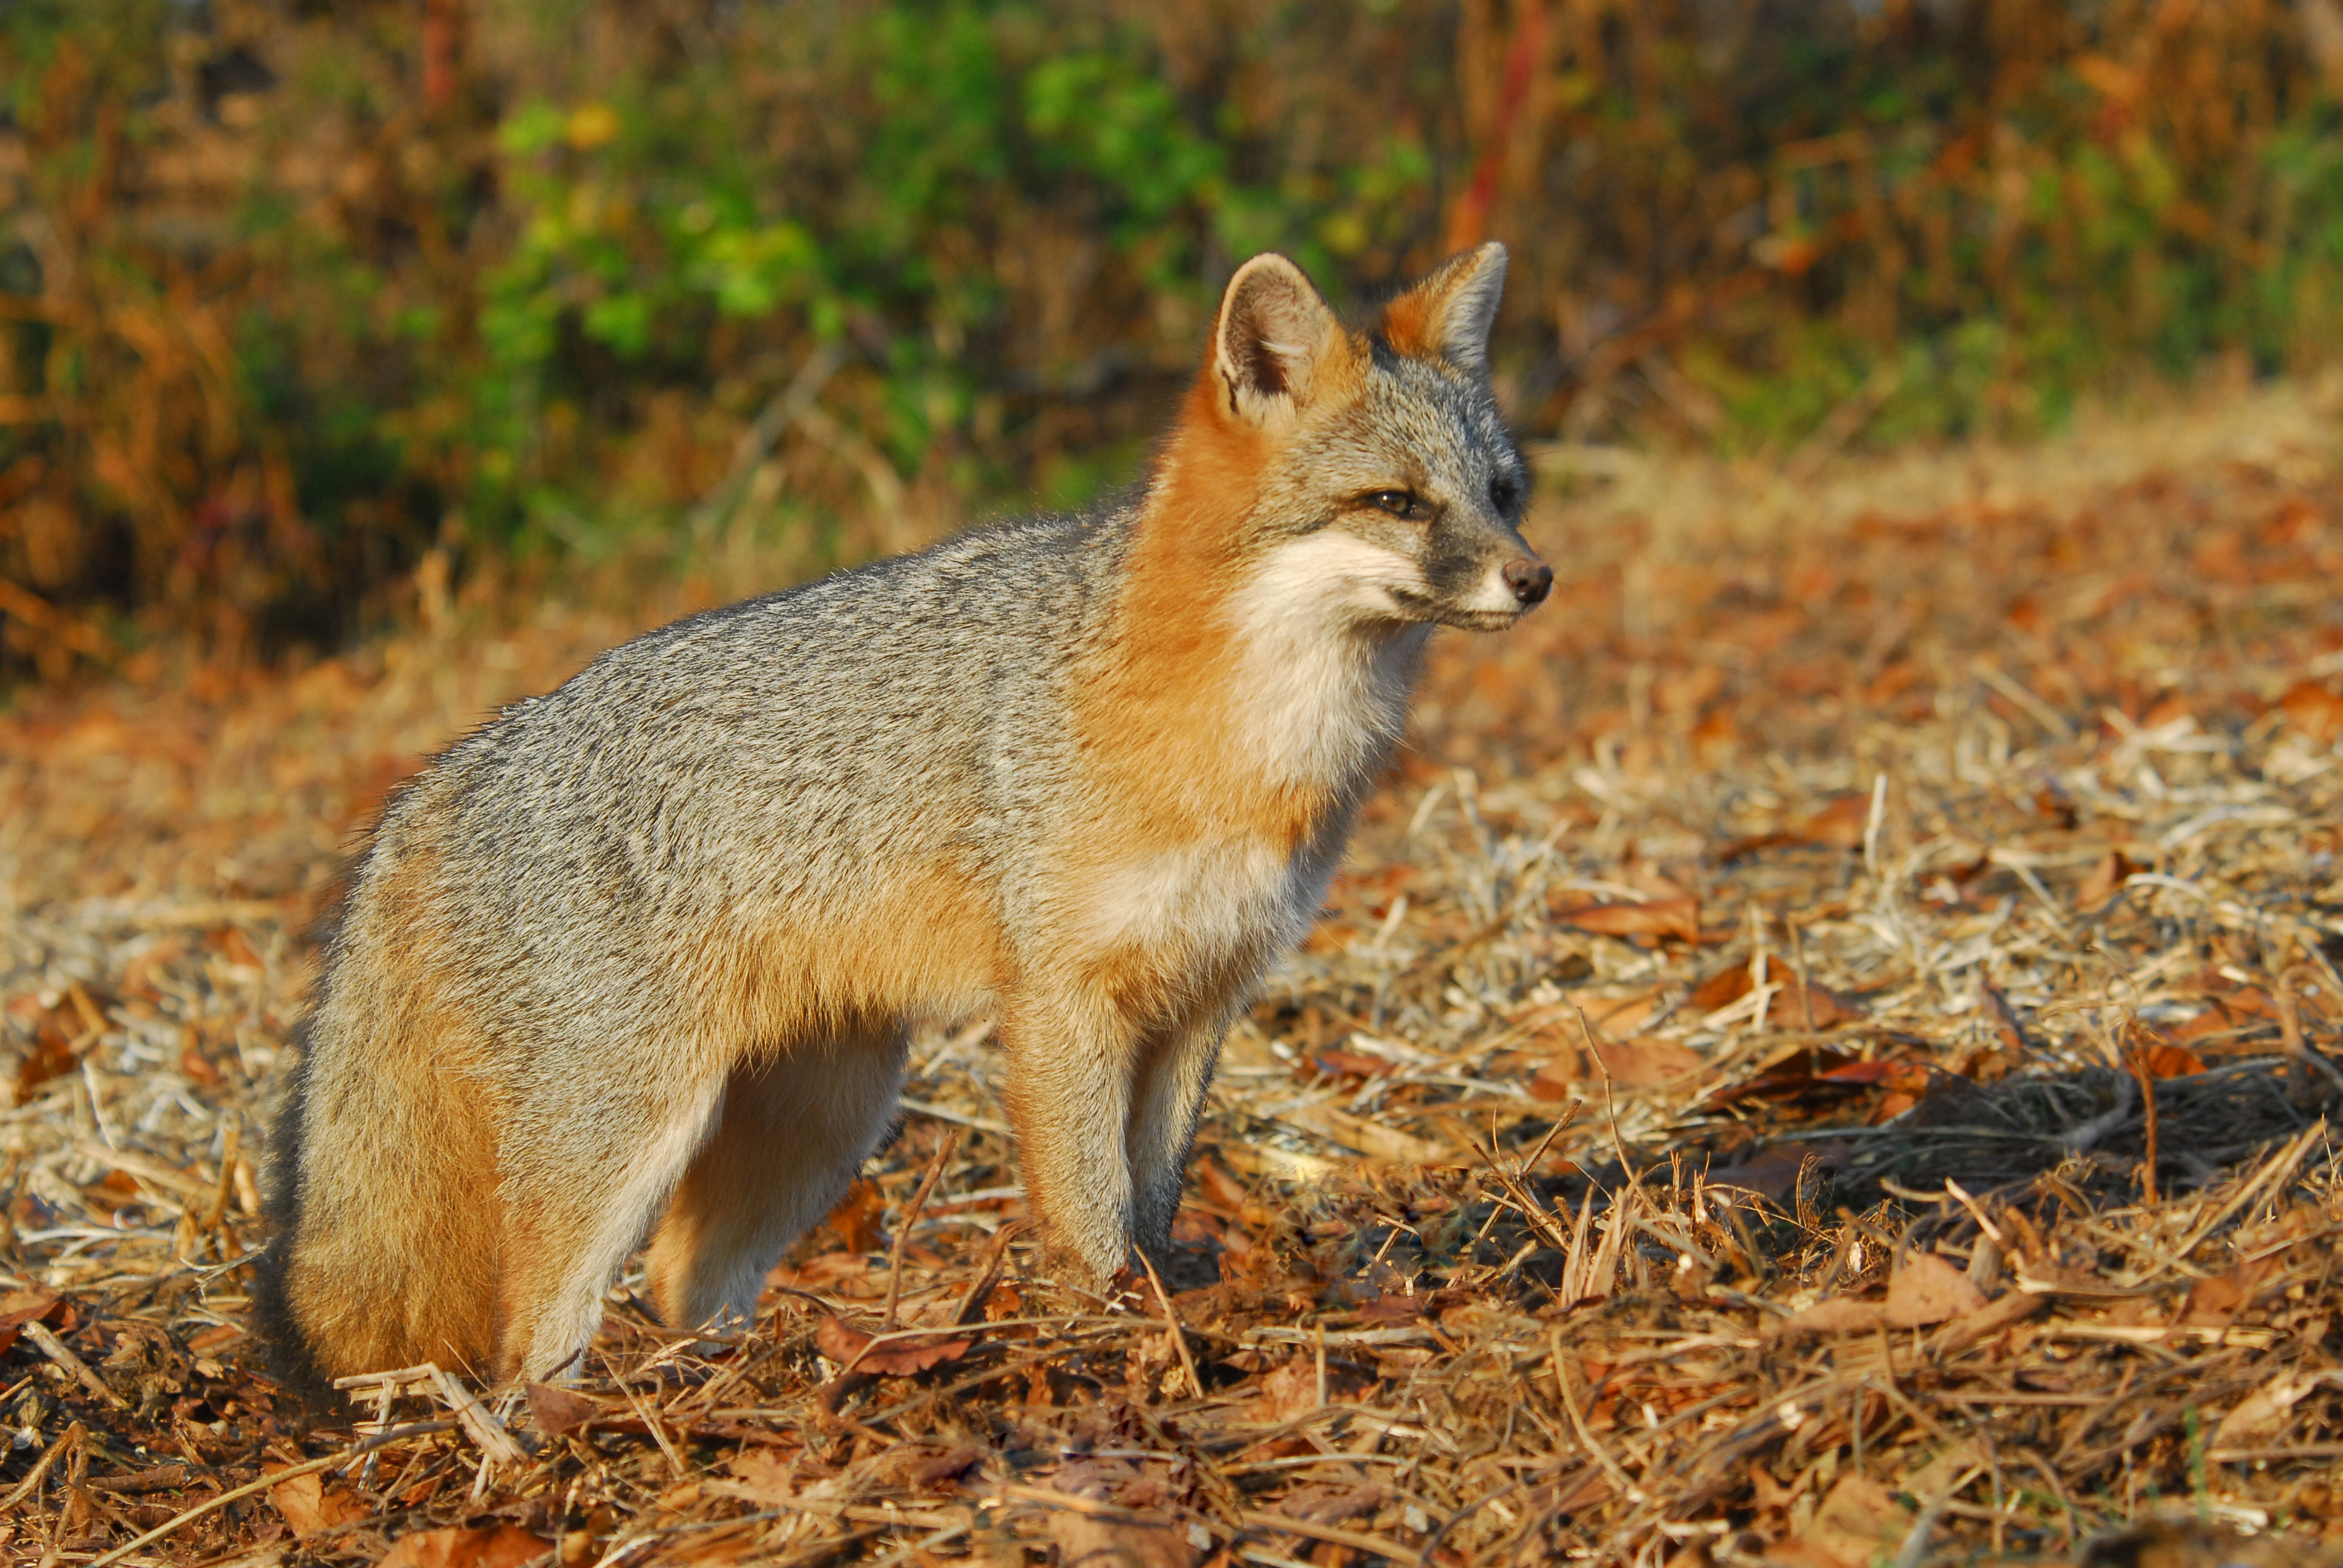

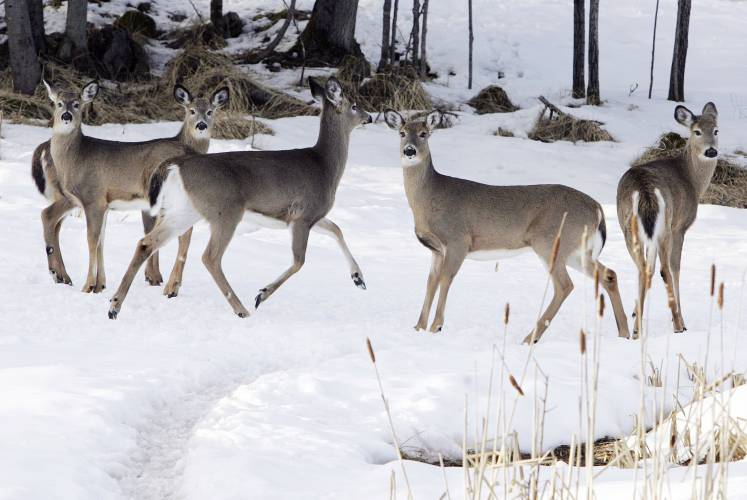

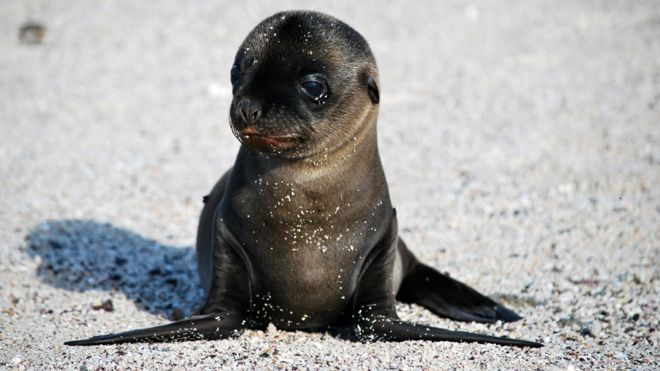

In [5]:
# random showing 3 iamges for you
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path, width=200, height=200))
#     print(image_path.split('\\')[-2])

In [6]:
# get the label
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
# total label
n_classes = len(label_names)
print(label_names)

['bald_eagle', 'black_bear', 'cougar', 'deer', 'nutria', 'raccoon', 'raven', 'red_fox', 'sea_lions', 'virginia_opossum']


In [7]:
# get the mapping dict
label_to_index = dict((name, index) for index,name in enumerate(label_names))
index_to_label = dict((index, name) for index,name in enumerate(label_names))
print(label_to_index)

{'bald_eagle': 0, 'black_bear': 1, 'cougar': 2, 'deer': 3, 'nutria': 4, 'raccoon': 5, 'raven': 6, 'red_fox': 7, 'sea_lions': 8, 'virginia_opossum': 9}


In [8]:
# get the label data
all_image_label = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]
print("First 10 label indices: ", all_image_label[:10])

First 10 label indices:  [8, 5, 2, 5, 0, 2, 1, 0, 1, 0]


In [9]:
# Create training and testing sets using an 80-20 split
img_path_train, img_path_test, label_train, label_test = train_test_split(all_image_paths,
                                all_image_label,test_size=0.2,random_state=0)
print('training data: %d'%(len(img_path_train)))
print('testing data: %d'%(len(img_path_test)))

training data: 5734
testing data: 1434


In [10]:
# save (img_path, label) pairs
with open('train.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['img_path', 'label'])
    for img_path, label in zip(img_path_train, label_train):
        writer.writerow([img_path, label])
        
with open('test.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['img_path', 'label'])
    for img_path, label in zip(img_path_test, label_test):
        writer.writerow([img_path, label])

In [11]:
# Feel free to change IMAGE_SIZE_CROPPED if using random_crop in your data augmentation process, but make sure the input resize back to (300,300,3) before feed into VGG16
IMAGE_SIZE_CROPPED = 224
IMAGE_HEIGHT = 300
IMAGE_WIDTH = 300
IMAGE_DEPTH = 3

In [12]:
# construct a new dataset with time informantion
class TimeMeasuredDataset(tf.data.Dataset):
    # OUTPUT: (steps, timings, counters, img, label)
    OUTPUT_SIGNATURE=(
        tf.TensorSpec(shape=(2, 1), dtype=tf.string), # steps: [("Open",), ("Read",)]
        tf.TensorSpec(shape=(2, 2), dtype=tf.float32), # timings: [(open_enter, open_elapsed), (read_enter, read_elapsed)]
        tf.TensorSpec(shape=(2, 3), dtype=tf.int32), # counters: [(instance_idx, epoch_idx, -1), (instance_idx, epoch_idx, example_idx)]
        tf.TensorSpec(shape=(300,300,3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32) # label
    )

    _INSTANCES_COUNTER = itertools.count()  # Number of datasets generated
    _EPOCHS_COUNTER = defaultdict(itertools.count)  # Number of epochs done for each dataset

    def _generator(instance_idx, filename, open_file, read_file):
        epoch_idx = next(TimeMeasuredDataset._EPOCHS_COUNTER[instance_idx])

        # Opening the file
        open_enter = time.perf_counter()
        img_paths, label = open_file(filename)
        open_elapsed = time.perf_counter() - open_enter
        # ----------------
        
        # Reading the file        
        for sample_idx in range(len(img_paths)):
            # Reading data (line, record) from the file
            read_enter = time.perf_counter()
            img = read_file(img_paths[sample_idx])
            read_elapsed = time.perf_counter() - read_enter

            yield (
                [("Open",), ("Read",)],
                [(open_enter, open_elapsed), (read_enter, read_elapsed)],
                [(instance_idx, epoch_idx, -1), (instance_idx, epoch_idx, sample_idx)],
                img,
                label[sample_idx]
            )
            open_enter, open_elapsed = -1., -1.  # Negative values will be filtered


    def __new__(cls, filename, open_file, read_file):
        def generator_func(instance_idx, filename):
            return cls._generator(instance_idx, filename, open_file, read_file)

        return tf.data.Dataset.from_generator(
            generator_func,
            output_signature=cls.OUTPUT_SIGNATURE,
            args=(next(cls._INSTANCES_COUNTER), filename)
        )

In [13]:
def open_file(filename):
    rows = pd.read_csv(filename.decode("utf-8"))
    img_paths = rows['img_path'].tolist()
    label = rows['label'].tolist()
    return img_paths, label

def read_file(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=IMAGE_DEPTH)
    img = tf.image.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
    img = tf.cast(img, tf.float32)
    img = tf.divide(img,255.0)
    return img

def dataset_generator_fun_train(*args):
    return TimeMeasuredDataset('train.csv', open_file, read_file)

def dataset_generator_fun_test(*args):
    return TimeMeasuredDataset('test.csv', open_file, read_file)

In [14]:
# feel free to modify these two Settings.
BUFFER_SIZE = 10000
BATCH_SIZE = 16

dataset_train = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_train).batch(BATCH_SIZE, drop_remainder=True)
dataset_test = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_test).batch(BATCH_SIZE, drop_remainder=True)

tf.Tensor(
[[b'Open']
 [b'Read']], shape=(2, 1), dtype=string) tf.Tensor(
[[7.7515407 0.0126064]
 [7.764148  0.032878 ]], shape=(2, 2), dtype=float32) tf.Tensor(
[[ 0  0 -1]
 [ 0  0  0]], shape=(2, 3), dtype=int32)
(300, 300, 3)


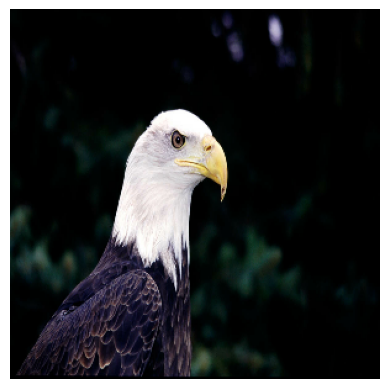

bald_eagle


In [15]:
for steps, timings, counters, img, label in dataset_train.take(1):
    print(steps[0], timings[0], counters[0])
    print(img[0].shape)
    plt.imshow(img[0]) 
    plt.axis('off') 
    plt.show()
    print(index_to_label[label[0].numpy()])

In [16]:
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(300, 300, 3),
    pooling=None,
)
for layer in base_model.layers:
    layer.trainable = False

top_model = models.Sequential()

top_model.add(layers.Flatten())
top_model.add(layers.Dense(4096, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(1024, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(n_classes, activation='softmax'))

In [17]:
wild_model = tf.keras.Model(inputs=base_model.input, outputs=top_model(base_model.output)) 

In [18]:
wild_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0     

In [19]:
top_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 41472)             0         
                                                                 
 dense (Dense)               (None, 4096)              169873408 
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              4195328   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 10)                10250     
                                                                 
Total params: 174,078,986
Trainable params: 174,078,986


In [20]:
# save the initialization of weights 
wild_model.save_weights('wild_model.h5')

In [21]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [22]:
@tf.function
def train_step(image, label):
    with tf.GradientTape() as tape:
        predictions = wild_model(image, training=True)
        loss = loss_object(label, predictions)
    gradients = tape.gradient(loss, wild_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, wild_model.trainable_variables))

    train_loss(loss)
    train_accuracy(label, predictions)
    
@tf.function
def test_step(image, label):
    predictions = wild_model(image, training=False)
    loss = loss_object(label, predictions)

    test_loss(loss)
    test_accuracy(label, predictions)

In [23]:
def timelined_benchmark(dataset_train, dataset_test, EPOCHS):
    steps_acc = tf.zeros([0, 1], dtype=tf.dtypes.string)
    times_acc = tf.zeros([0, 2], dtype=tf.dtypes.float32)
    values_acc = tf.zeros([0, 3], dtype=tf.dtypes.int32)

    start_time = time.perf_counter()
    print("start time: ", start_time)
    for epoch in range(EPOCHS):
        epoch_enter = time.perf_counter()

        # Reset the metrics at the start of the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()

        tf.print("training:")
        for steps, times, values, image, label in tqdm(dataset_train, total=math.floor(len(img_path_train)/BATCH_SIZE)):
            time.sleep(0.05)
            
            steps_acc = tf.concat([steps_acc, tf.reshape(steps, (steps.shape[0]*steps.shape[1], 1))], axis=0)
            times_acc = tf.concat([times_acc, tf.reshape(times, (times.shape[0]*times.shape[1], 2))], axis=0)
            values_acc = tf.concat([values_acc, tf.reshape(values, (values.shape[0]*values.shape[1], 3))], axis=0)

            # record training time
            train_enter = time.perf_counter()
            train_step(image, label)
            train_elapsed = time.perf_counter() - train_enter
            
            time.sleep(0.05)
            
            train_time = tf.concat([tf.fill([times.shape[0], 1], train_enter), tf.fill([times.shape[0], 1], train_elapsed)], axis=1) # shape=(times.shape[0], 2)
            steps_acc = tf.concat([steps_acc, tf.fill([steps.shape[0], 1], "Train")], axis=0)
            times_acc = tf.concat([times_acc, train_time], axis=0)
            values_acc = tf.concat([values_acc, values[:,-1,:]], axis=0)

        tf.print("testing:")
        for steps, times, values, image, label in tqdm(dataset_test, total=math.floor(len(img_path_test)/BATCH_SIZE)):
            time.sleep(0.05)
            
            steps_acc = tf.concat([steps_acc, tf.reshape(steps, (steps.shape[0]*steps.shape[1], 1))], axis=0)
            times_acc = tf.concat([times_acc, tf.reshape(times, (times.shape[0]*times.shape[1], 2))], axis=0)
            values_acc = tf.concat([values_acc, tf.reshape(values, (values.shape[0]*values.shape[1], 3))], axis=0)

            test_enter = time.perf_counter()
            test_step(image, label)
            test_elapsed = time.perf_counter() - test_enter
            
            time.sleep(0.05)
            
            test_time = tf.concat([tf.fill([times.shape[0], 1], test_enter), tf.fill([times.shape[0], 1], test_elapsed)], axis=1) # shape=(times.shape[0], 2)
            steps_acc = tf.concat([steps_acc, tf.fill([steps.shape[0], 1], "Test")], axis=0)
            times_acc = tf.concat([times_acc, test_time], axis=0)
            values_acc = tf.concat([values_acc, values[:,-1,:]], axis=0)
            
        template = 'Epoch {:0}, Loss: {:.4f}, Accuracy: {:.4f}, test Loss: {:.4f}, test Accuracy: {:.4f}'
        tf.print (template.format(epoch+1,
                               train_loss.result(),
                               train_accuracy.result()*100,
                               test_loss.result(),
                               test_accuracy.result()*100))

        epoch_elapsed = time.perf_counter() - epoch_enter
        steps_acc = tf.concat([steps_acc, [["Epoch"]]], axis=0)
        times_acc = tf.concat([times_acc, [(epoch_enter, epoch_elapsed)]], axis=0)
        values_acc = tf.concat([values_acc, [[-1, epoch, -1]]], axis=0)

    tf.print("Execution time:", time.perf_counter() - start_time)
    return {"steps": steps_acc, "times": times_acc, "values": values_acc}

In [24]:
timeline_Naive = timelined_benchmark(dataset_train, dataset_test, EPOCHS=3)

start time:  9.6868987
training:


  0%|          | 0/358 [00:00<?, ?it/s]

100%|██████████| 358/358 [01:55<00:00,  3.10it/s]

testing:



100%|██████████| 89/89 [00:28<00:00,  3.13it/s]

Epoch 1, Loss: 3.9022, Accuracy: 31.0754, test Loss: 1.2244, test Accuracy: 62.2893
training:



100%|██████████| 358/358 [01:54<00:00,  3.11it/s]

testing:



100%|██████████| 89/89 [00:28<00:00,  3.17it/s]

Epoch 2, Loss: 1.5522, Accuracy: 45.8275, test Loss: 0.9707, test Accuracy: 69.8736
training:



100%|██████████| 358/358 [01:52<00:00,  3.19it/s]

testing:



100%|██████████| 89/89 [00:28<00:00,  3.13it/s]

Epoch 3, Loss: 1.3737, Accuracy: 52.4791, test Loss: 0.7922, test Accuracy: 77.5983
Execution time: 427.7933733


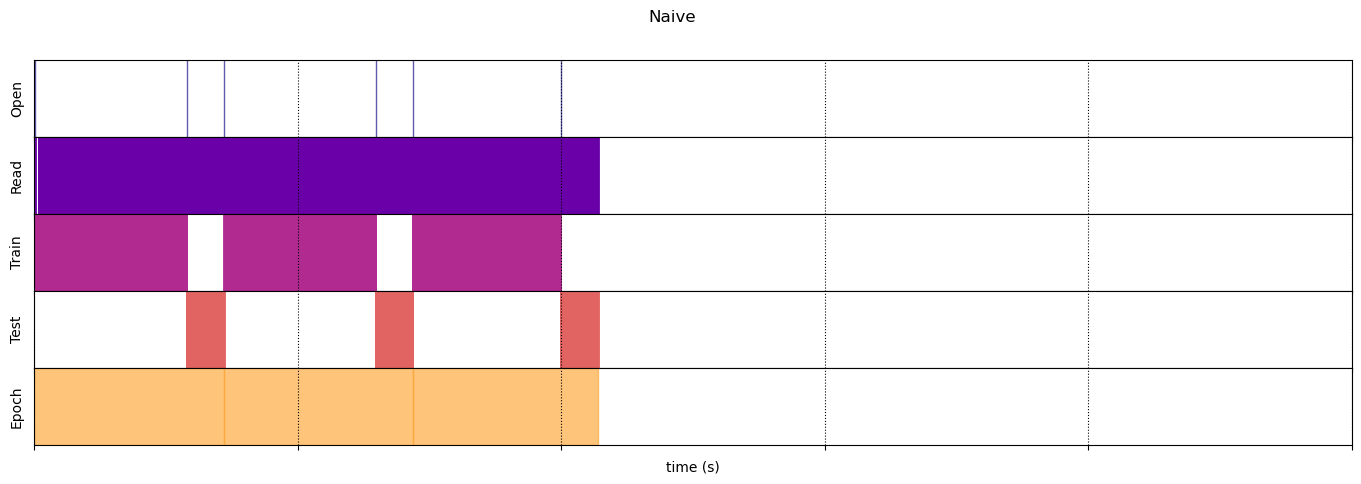

In [25]:
import urllib.request
if not os.path.exists("lab11_1_lib.py"):
    urllib.request.urlretrieve("https://nthu-datalab.github.io/ml/labs/11-1_CNN/lab11_1_lib.py", "lab11_1_lib.py")

from lab11_1_lib import draw_timeline

draw_timeline(timeline=timeline_Naive, title="Naive", min_width=1000)

In [47]:
def map_decorator(func):
    def wrapper(steps, times, values, image, label):
        # Use a tf.py_function to prevent auto-graph from compiling the method
        return tf.py_function(
            func,
            inp=(steps, times, values, image, label),
            Tout=(steps.dtype, times.dtype, values.dtype, image.dtype, tf.float32)
        )
    return wrapper



@tf.function
def map_fun_with_time_batchwise(steps, times, values, image, label):
    # sleep to avoid concurrency issue
    time.sleep(0.05)
    
    map_enter = time.perf_counter()
    
    distorted_image = tf.image.random_flip_left_right(image)
    distorted_image = tf.image.random_brightness(distorted_image, max_delta=63)
    distorted_image = tf.image.random_contrast(distorted_image, lower=0.2, upper=1.8)
    distorted_image = tf.image.per_image_standardization(distorted_image)
    
    map_elapsed = time.perf_counter() - map_enter

    return tf.concat((steps, tf.tile([[["Map"]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((values, tf.tile([[values[:][-1][0]]], [BATCH_SIZE, 1, 1])), axis=1),\
           distorted_image,\
           label


@tf.function
def map_fun_test_with_time_batchwise(steps, times, values, image, label):
    # sleep to avoid concurrency issue
    time.sleep(0.05)
    
    map_enter = time.perf_counter()
    
    distorted_image = tf.image.per_image_standardization(image)
    
    map_elapsed = time.perf_counter() - map_enter
    
    return tf.concat((steps, tf.tile([[["Map"]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((values, tf.tile([[values[:][-1][0]]], [BATCH_SIZE, 1, 1])), axis=1),\
           distorted_image,\
           label

In [48]:
## TODO: build `dataset_train_augmentation` and `dataset_test_augmentation` with transformation
## Remember to define your own map functions with map_decorator before calling map

dataset_train_augmentation = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_train)\
                                        .shuffle(BUFFER_SIZE)\
                                        .batch(BATCH_SIZE, drop_remainder=True)\
                                        .map(map_fun_with_time_batchwise)

dataset_test_augmentation = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_test)\
                                        .batch(BATCH_SIZE, drop_remainder=True)\
                                        .map(map_fun_test_with_time_batchwise) 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[[b'Open']
 [b'Read']
 [b'Map']], shape=(3, 1), dtype=string) tf.Tensor(
[[-1.0000000e+00 -1.0000000e+00]
 [ 2.4918447e+03  4.2550000e-03]
 [ 2.4325339e+03  1.7711600e-02]], shape=(3, 2), dtype=float32) tf.Tensor(
[[  14    0   -1]
 [  14    0 4528]
 [  14    0   -1]], shape=(3, 3), dtype=int32)
(300, 300, 3)


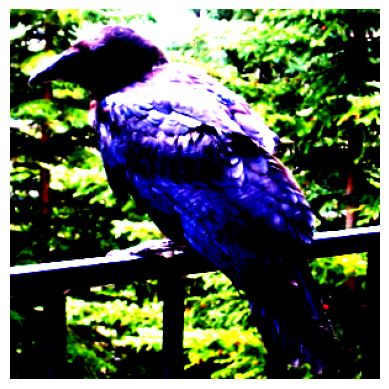

raven


In [49]:
for steps, timings, counters, img, label in dataset_train_augmentation.take(1):
    print(steps[0], timings[0], counters[0])
    print(img[0].shape)
    plt.imshow(img[0]) 
    plt.axis('off') 
    plt.show()
    print(index_to_label[label[0].numpy()])

In [50]:
# load the same initialization of weights and re-train with optimized input pipeline
wild_model.load_weights('wild_model.h5')
timeline_Augmentation = timelined_benchmark(dataset_train_augmentation, dataset_test_augmentation, EPOCHS=3)

start time:  2654.0605307
training:


100%|██████████| 358/358 [02:13<00:00,  2.68it/s]

testing:



100%|██████████| 89/89 [00:23<00:00,  3.72it/s]

Epoch 1, Loss: 7.8710, Accuracy: 38.6522, test Loss: 0.9564, test Accuracy: 74.7893
training:



100%|██████████| 358/358 [02:17<00:00,  2.60it/s]

testing:



100%|██████████| 89/89 [00:21<00:00,  4.21it/s]

Epoch 2, Loss: 1.2824, Accuracy: 60.7891, test Loss: 0.6087, test Accuracy: 84.9017
training:



100%|██████████| 358/358 [02:16<00:00,  2.62it/s]

testing:



100%|██████████| 89/89 [00:21<00:00,  4.18it/s]

Epoch 3, Loss: 1.0463, Accuracy: 68.4532, test Loss: 0.4757, test Accuracy: 89.3258
Execution time: 474.05830160000005


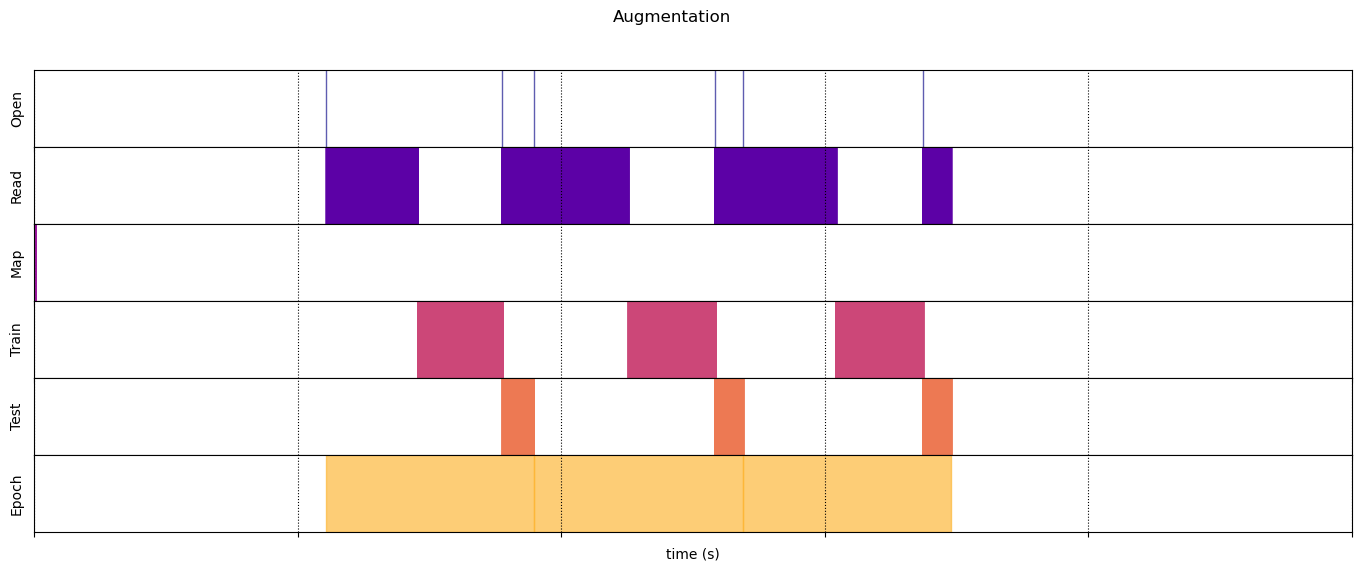

In [51]:
draw_timeline(timeline=timeline_Augmentation, title="Augmentation", min_width=1000)

In [52]:
## TODO: build `dataset_train_optimized` and `dataset_test_optimized` with transformation and optimzation
## Remember to re-define your own map functions again to make mapping time re-calculated

# dataset_train_optimized = tf.data.Dataset.range(1). ...
# dataset_test_optimized = tf.data.Dataset.range(1). ...

dataset_train_optimized = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_train)\
                                        .shuffle(BUFFER_SIZE)\
                                        .batch(BATCH_SIZE, drop_remainder=True)\
                                        .map(map_fun_with_time_batchwise)\
                                        .cache()\
                                        .prefetch(tf.data.AUTOTUNE)

dataset_test_optimized = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_test)\
                                        .batch(BATCH_SIZE, drop_remainder=True)\
                                        .map(map_fun_test_with_time_batchwise)\
                                        .cache()\
                                        .prefetch(tf.data.AUTOTUNE) 


In [53]:
# load the same initialization of weights and re-train with optimized input pipeline
wild_model.load_weights('wild_model.h5')
timeline_Optimized = timelined_benchmark(dataset_train_optimized, dataset_test_optimized, EPOCHS=3)

start time:  3130.5564545
training:


100%|██████████| 358/358 [02:01<00:00,  2.95it/s]

testing:



100%|██████████| 89/89 [00:20<00:00,  4.28it/s]

Epoch 1, Loss: 6.4939, Accuracy: 37.3778, test Loss: 1.0522, test Accuracy: 67.4157
training:



100%|██████████| 358/358 [00:50<00:00,  7.05it/s]

testing:



100%|██████████| 89/89 [00:11<00:00,  7.91it/s]

Epoch 2, Loss: 1.5113, Accuracy: 56.1627, test Loss: 0.7735, test Accuracy: 75.7725
training:



100%|██████████| 358/358 [00:51<00:00,  6.98it/s]

testing:



100%|██████████| 89/89 [00:11<00:00,  7.77it/s]

Epoch 3, Loss: 1.1290, Accuracy: 66.3582, test Loss: 0.4546, test Accuracy: 86.2360
Execution time: 267.0767246999999


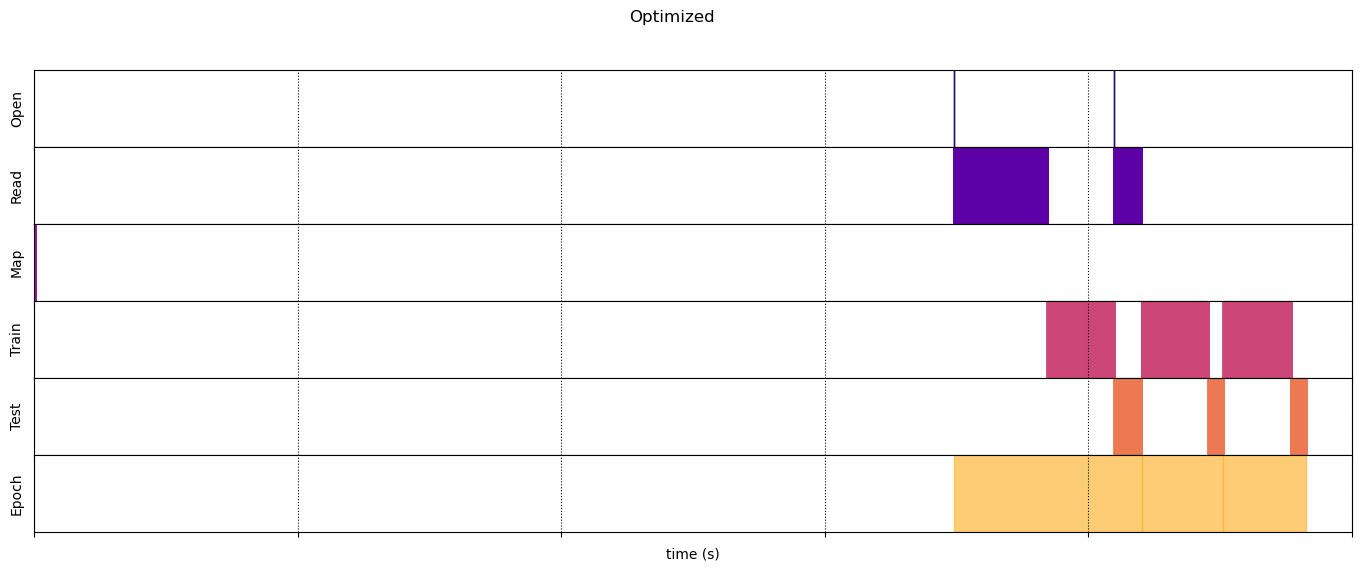

In [54]:
draw_timeline(timeline=timeline_Optimized, title="Optimized", min_width=1000)

這次的實驗主要是對數據進行增強，並觀察其對準確度的影響。結果發現，進行數據增強可以顯著提高準確度，從原本的77.5983%提升到了89.3258%。這充分證明了對數據進行進一步處理的重要性。
最後，我們將增強過後的數據集利用 cache 和 prefetch 進行加速。從時間圖表中可以看出，這也確實大大減少了處理時間。